#Using machine learning for audio classification on the UrbanSound8K dataset.

First, download and unzip the data

In [ ]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
!tar -xvf UrbanSound8K.tar.gz

In [ ]:
# install dependencies
!pip install torchaudio==0.9.0

In [3]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchaudio
import librosa
import librosa.display
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from pprint import pprint

In [4]:
# Saving the path to the .wav files, loading in the metadeta into a pandas DataFrame, and extracing out the labels.
data_path = '/content/UrbanSound8K/audio'
metadeta = pd.read_csv("/content/UrbanSound8K/metadata/UrbanSound8K.csv")
labels = list(metadeta['class'].unique())

In [5]:
metadeta

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [6]:
labels

['dog_bark',
 'children_playing',
 'car_horn',
 'air_conditioner',
 'street_music',
 'gun_shot',
 'siren',
 'engine_idling',
 'jackhammer',
 'drilling']

There are 8732 samples, each being a .wav file of one of the sounds listed in the cell above.

The .wav files are randomsly shuffled among 10 different folders.

Now lets extract a sample out from each class and take a look.

In [7]:
files = {}
for i in range(len(labels)):
    # get the first sample in the dataframe for each class
    temp = metadeta.loc[metadeta['class'] == labels[i]].iloc[0]
    num_fold = temp['fold']
    file_name = temp['slice_file_name']
    path = data_path + f"/fold{num_fold}/{file_name}"
    files[labels[i]] = path
pprint(files)


{'air_conditioner': '/content/UrbanSound8K/audio/fold5/100852-0-0-0.wav',
 'car_horn': '/content/UrbanSound8K/audio/fold10/100648-1-0-0.wav',
 'children_playing': '/content/UrbanSound8K/audio/fold5/100263-2-0-117.wav',
 'dog_bark': '/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav',
 'drilling': '/content/UrbanSound8K/audio/fold3/103199-4-0-0.wav',
 'engine_idling': '/content/UrbanSound8K/audio/fold10/102857-5-0-0.wav',
 'gun_shot': '/content/UrbanSound8K/audio/fold1/102305-6-0-0.wav',
 'jackhammer': '/content/UrbanSound8K/audio/fold1/103074-7-0-0.wav',
 'siren': '/content/UrbanSound8K/audio/fold7/102853-8-0-0.wav',
 'street_music': '/content/UrbanSound8K/audio/fold7/101848-9-0-0.wav'}


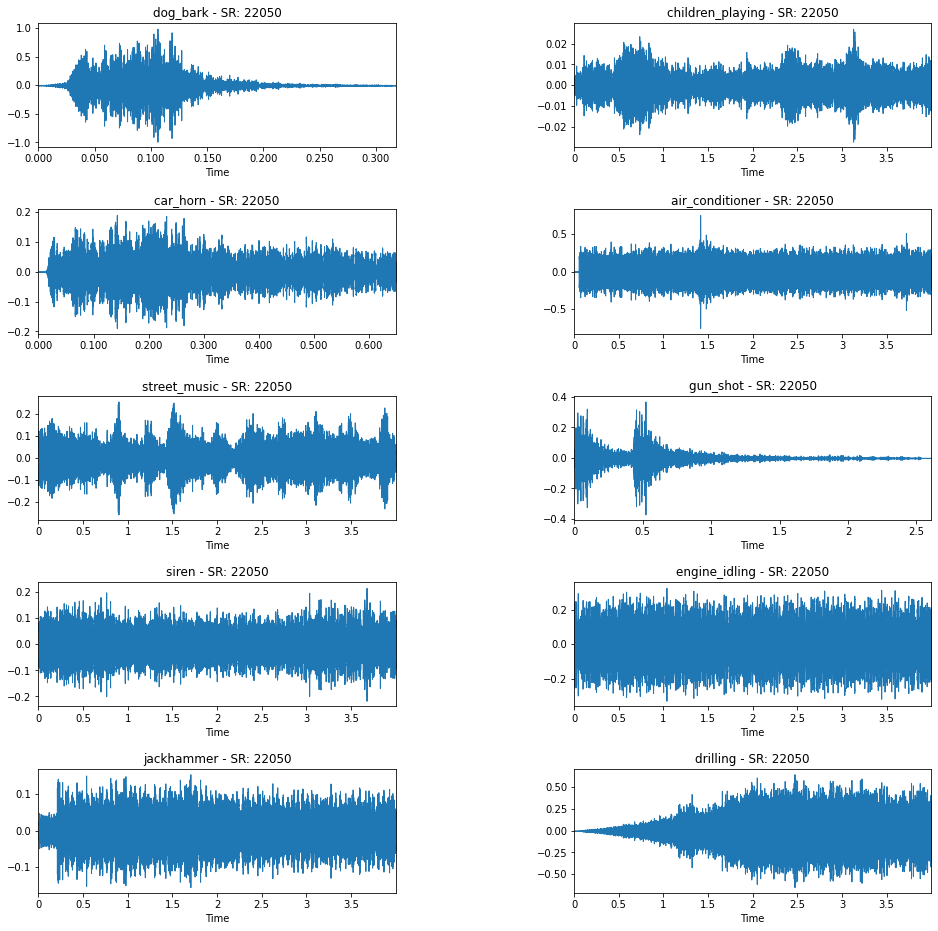

In [9]:
# # Extracting waveform and sample rate with torchaudio and plotting with matplotlib
# plt.figure(figsize=(16, 16))
# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# for i, label in enumerate(labels):
#     file_name = files[label]
#     plt.subplot(5, 2, i+1)
    
#     waveform, sample_rate = torchaudio.load(file_name)
#     plt.title(f"{label} - SR: {sample_rate}")
#     # Make sure to convert waveform to mono instead of stereo
#     mono = torch.mean(waveform, dim=0)
#     plt.plot(mono.numpy())

# Extracting waveform and sample rate with librosa and plotting with librosa
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, label in enumerate(labels):
    file_name = files[label]
    plt.subplot(5, 2, i+1)
    
    waveform, sample_rate = librosa.load(file_name)
    plt.title(f"{label} - SR: {sample_rate}")
    librosa.display.waveplot(waveform, sr=sample_rate)

torchaudio:
- you can extract the waveform and the sample rate from each file, and torchaudio automatically adjusts our bit depth to be between -1 and 1, as you can see from the yaxis of our plots. However, our waveforms were in stereo form (two channels, left and right) and so we had to change things up so that the audio is mono (one source) by applying torch.mean().

librosa:
- librosa is a little more friendly in that it also automatically adjusts the bit depth to be between -1 and 1, but it also automatically turns the waveforms into mono if they are stereo.
- librosa also automatically resamples all data so that the sample rate is 22050

(40, 173)


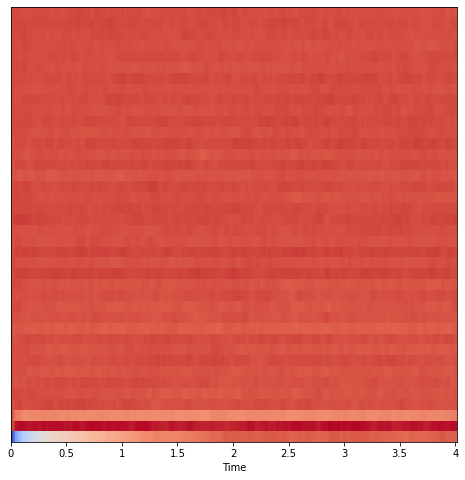

In [22]:
# # torchaudio mfcc extraction function
# mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=40)

# def extract_mfcc(file_name):
#     """ Extract 40 MFCC from a given waveform file """
#     waveform, sample_rate = torchaudio.load(file_name)
#     mono = torch.mean(waveform, dim=0)
#     transformed = mfcc_transform.forward(mono)
#     avg = torch.mean(transformed.T, axis=0)
#     mfcc = list(avg.numpy())
#     return mfcc

# librosa mfcc extraction function
def extract_mfcc(file_name):
    waveform, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    orig_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40)
    mfcc = np.mean(orig_mfcc.T, axis=0)
    return mfcc

mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(8, 8))
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
print(mfcc.shape)

When extracting mfcc with torchaudio, you get a shape of (40, ~870), meanwhile with librosa you get a shape of (40, 173)

In [23]:
features = []
for index, row in metadeta.iterrows():
    num_fold = row['fold']
    file_name = row['slice_file_name']
    class_name = row['class']
    path = data_path + f"/fold{num_fold}/{file_name}"
    feature = extract_mfcc(path)
    features.append([feature, class_name, num_fold])
features_df = pd.DataFrame(features, columns=['feature', 'label', 'folder_number'])
features_df

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


,feature,label,folder_number
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark,5
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing,5
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing,5
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing,5
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing,5
...,...,...,...
8727,"[-399.2257, 136.81903, -51.964222, 37.02399, -...",car_horn,7
8728,"[-346.72733, 87.48847, -46.265022, 52.748833, ...",car_horn,7
8729,"[-304.61316, 112.6199, -47.16195, 37.00349, -1...",car_horn,7
8730,"[-344.71423, 126.75813, -56.17717, 36.070927, ...",car_horn,7


We have extracted the mfcc from each file and built a dataframe that holds all of them under the 'feature' column, along with all the labels and the folder from which each came from. The reason why we need the folder is so that we can test both methods of training. The first being the optimal way as specified by the people behind the UrbanSound8K dataset, which is to use K-Fold Cross Validation but with the splits being the folders into which all the files were split already. The second method being a non-optimal training where we simply use sklearn's train_test_split function on the entire dataframe and do not use any sort of K-Fold Cross Validation.

In [24]:
class CustomKFOLDDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
NUM_MFCCS = 40
NUM_LABELS = 10

class SimpleFeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NUM_MFCCS, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_LABELS)
        )

    def forward(self, x):
        return self.layers(x)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        X, y = data[0].to(device), data[1].to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# test loop for optimal k-fold training
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            X, y = data[0].to(device), data[1].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    result = 100 * (correct / size)
    print(f"Test Error: \n Accuracy: {(result):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return result

In [42]:
LR = 0.001

model = SimpleFeedForward().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [43]:
K_FOLD = 10
NUM_EPOCHS = 20
BATCH_SIZE = 32
results = {}

le = LabelEncoder()
for fold in range(1, K_FOLD+1):
    print(f"K-Fold {fold}\n-------------------------------")
    curr_fold_train = features_df.loc[~(features_df['folder_number'] == fold)]
    train_labels = np.array(curr_fold_train.label.tolist())

    curr_fold_test = features_df.loc[features_df['folder_number'] == fold]
    test_labels = np.array(curr_fold_test.label.tolist())

    X_train = np.array(curr_fold_train.feature.tolist())
    y_train = le.fit_transform(train_labels)
    training_data = CustomKFOLDDataset(X_train, y_train)

    X_test = np.array(curr_fold_test.feature.tolist())
    y_test = le.fit_transform(test_labels)
    testing_data = CustomKFOLDDataset(X_test, y_test)

    train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

    for t in range(NUM_EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        result = test_loop(test_dataloader, model, loss_fn)
        results[fold] = result

print(f"K-Fold Cross Validation Results for {K_FOLD} Folds")
print("-------------------------------------------------")
sum = 0.0
for key, value in results.items():
    print(f"Fold {key}: {value} %")
    sum += value
print(f"Average: {sum/len(results.items())} %")

K-Fold 1
-------------------------------
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 28.9%, Avg loss: 2.106945 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 30.5%, Avg loss: 2.107874 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 37.6%, Avg loss: 1.970708 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.186602 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 41.8%, Avg loss: 2.249618 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 42.0%, Avg loss: 2.276886 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 43.3%, Avg loss: 2.557356 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 43.1%, Avg loss: 2.581931 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.737199 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 44.1%, Avg loss: 2.882789 

Epoch 11
-----------------------------

In [44]:
# test loop for non-optimal k-fold training
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            X, y = data[0].to(device), data[1].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    result = 100 * (correct / size)
    print(f"Test Error: \n Accuracy: {(result):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
LR = 0.001

model = SimpleFeedForward().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [50]:
from sklearn.model_selection import train_test_split 


NUM_EPOCHS = 100
BATCH_SIZE = 32

le = LabelEncoder()

X = np.array(features_df.feature.tolist())
labels = np.array(features_df.label.tolist())
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 127)

training_data = CustomKFOLDDataset(X_train, y_train)
testing_data = CustomKFOLDDataset(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 28.2%, Avg loss: 1.989906 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 38.5%, Avg loss: 1.749456 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 42.4%, Avg loss: 1.591142 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 51.1%, Avg loss: 1.436283 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.327059 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.280555 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.191778 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 60.8%, Avg loss: 1.190251 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.112482 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 63.1%, Avg loss: 1.124226 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 65.4%, Avg los

Expectedly, the optimal training resulted in a 69% accuracy and the non-optimal resulted in 79% accuracy. The people behind UrbanSound8K say that results are not valid unless training happens optimally, with the valid K-Fold split. Unfortuneately for us that means the higher accuracy does not count :(